In [1]:
import sys
sys.path.append('../../')

In [2]:
from scripts.utils import data_path, set_mpl, read_london, add_datetime_features, get_spectrogram
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
set_mpl()
%matplotlib widget

matplotlib settings set
matplotlib settings set


In [3]:
data_std, _, weather, twitter = read_london()

data_std = data_std.query('index>"2012-01-01"')
weather = weather.query('index>"2012-01-01"')
twitter = twitter.query('index>"2012-01-01"')


    Loading London data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Weather from `meteostat` package.

    STD and ToU tariffs are separated.
    Data resampled (mean) to 1H resolution from original 30min resolution.

    reutrns:
    df_std: pd.DataFrame with STD tariff data
    df_tou: pd.DataFrame with ToU tariff data
    df_weather: pd.DataFrame with weather data
    df_twitter: pd.DataFrame with twitter data (see `0_data/2.2_london_twitter.ipynb` for details)
    
    


In [4]:
missed_frac = data_std.isna().mean(axis = 0).sort_values(ascending = False)
#drop columns with more than xx% missing values
data = data_std.drop(missed_frac[missed_frac > 0.3].index, axis = 1)
homes_col = data.columns

cols = data.columns

#data['homes_num'] = data[cols].count(axis=1)
#data['power_avg'] = data[cols].sum(axis=1)/data['homes_num']

In [5]:
#select homes with mean energy consumption close to  0.1
data_cluster = data[cols[ (data[cols].mean() > 0.1) & (data[cols].mean() < 0.115) ]]
print(f"number of homes: {data_cluster.shape[1]}")
power_avg = data_cluster.mean(axis=1).to_frame()
power_avg.columns = ['power_avg']


number of homes: 222


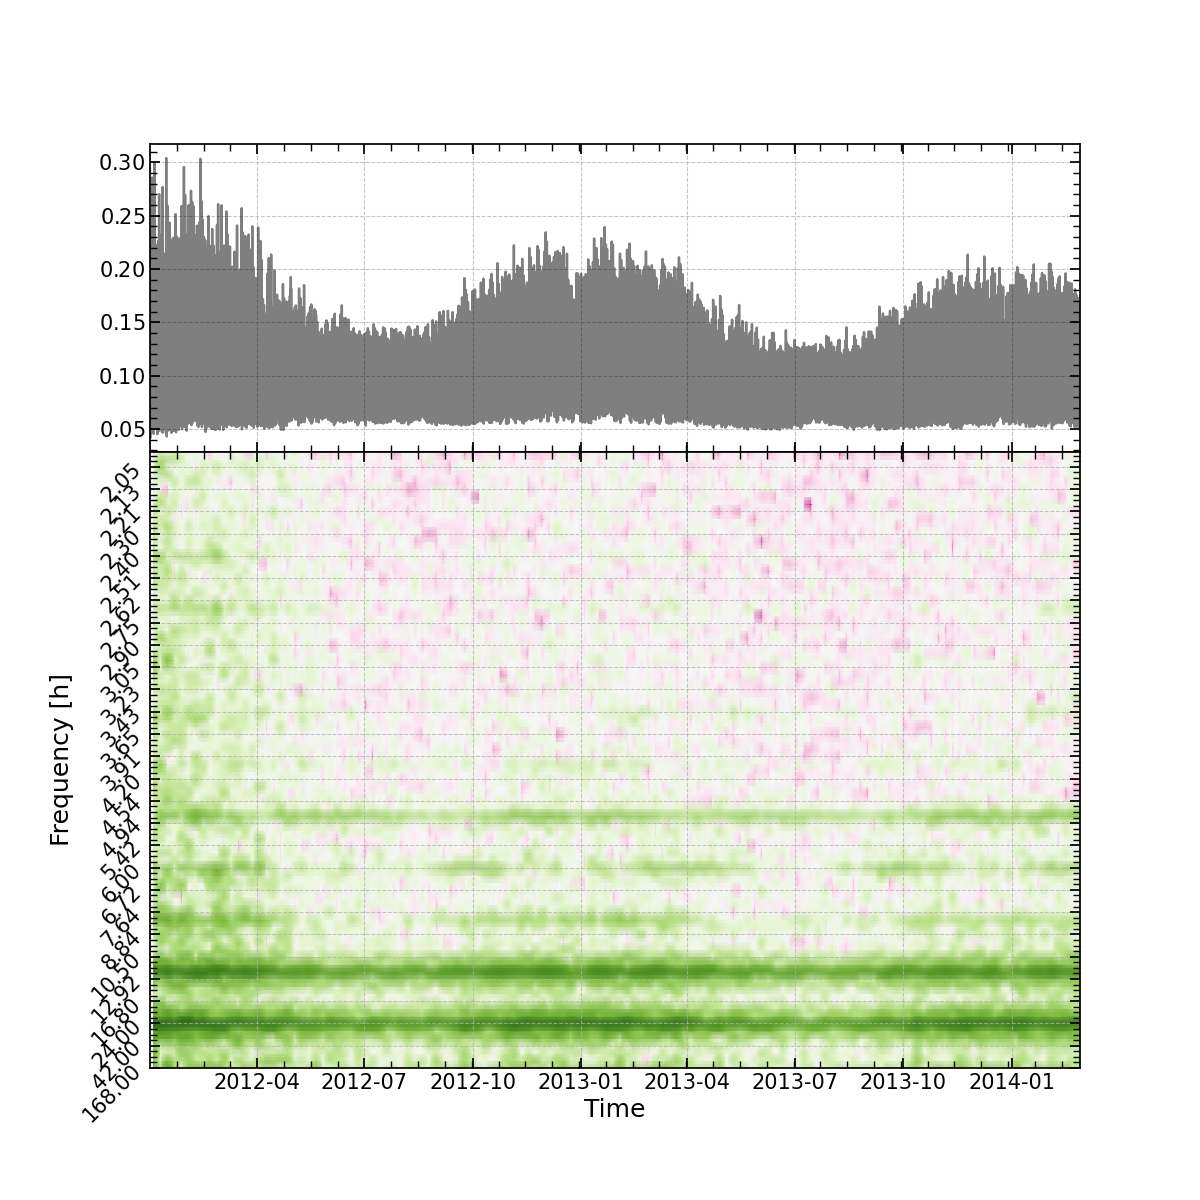

In [6]:
#get spectrogram
power_avg_spe = get_spectrogram(power_avg, 'power_avg', 24*7, 24, plot = True)
power_avg_spe = power_avg_spe/np.max(power_avg_spe, axis = 0)


In [7]:
#time series modelling with random forest and covariates

from darts import TimeSeries
from darts.metrics import mape
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr


target_orig = TimeSeries.from_dataframe(power_avg, freq = 'H')

hodidays_covariates = target_orig.add_holidays("UK")['holidays']

frequency_covariates = TimeSeries.from_dataframe(power_avg_spe[['24.00', '12.00', '6.00']], freq = 'H')


temperature_history = weather['temp']/np.max(weather['temp'])
#perturb temperature to avoid perfect correlation
rolling_std = temperature_history.rolling(24*3).std()
temperature_forecast = temperature_history + np.random.normal(0, rolling_std, size = len(temperature_history))

#temperature_covariate_past = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
#temperature_covariate_future  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
temperature_covariate  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H') #we can use it as past and future, although it is not perfect for past predictions

twitter_covariate = TimeSeries.from_dataframe(twitter[['tweets_total']], freq = 'H')

#datetime encodings (normalized)
datetime_covatiates = concatenate(
    [
        dt_attr(time_index = target_orig.time_index, attribute =  "hour", one_hot = False, cyclic = False )/24,
        dt_attr(time_index = target_orig.time_index, attribute =  "day_of_week", one_hot = False, cyclic = False )/7,
        dt_attr(time_index = target_orig.time_index, attribute =  "month", one_hot = False, cyclic = False )/12,
        dt_attr(time_index = target_orig.time_index, attribute =  "day_of_year", one_hot = False, cyclic = False )/365,
    ],
    axis="component",
)

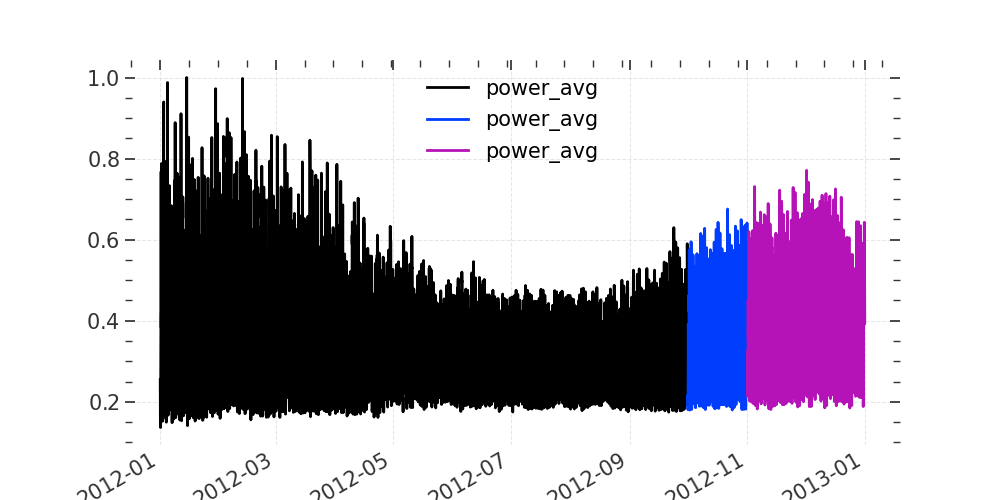

In [8]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mape, mase

from sklearn.preprocessing import MaxAbsScaler

target, _ = target_orig.split_before(pd.Timestamp('2013-01-01')) #remove some data for smaller dataset
train, val = target.split_before(pd.Timestamp('2012-10-01'))
val, test = val.split_before(pd.Timestamp('2012-11-01'))

scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

val_len = len(val)


fig,  ax =  plt.subplots( figsize = (10,5))

train.plot(ax = ax)
val.plot(ax = ax)
test.plot(ax = ax)



## catboost model

In [11]:
from darts.models import LightGBMModel, XGBModel

lags_horizon = 24
cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates, temperature_forecast], "past_covariates": [frequency_covariates, twitter_covariate]}


model_lgb = LightGBMModel(lags_future_covariates = (lags_horizon, lags_horizon) , lags_past_covariates=lags_horizon)

model_xgb = XGBModel(lags_future_covariates = (lags_horizon, lags_horizon) , lags_past_covariates=lags_horizon)





In [12]:
model_xgb.fit(train, **cov_args)

In [ ]:
model_lgb.fit(train, **cov_args)

In [29]:
from darts.models import CatBoostModel, LightGBMModel

lags_horizon = 24


model_naive = val.shift(+24*7) #repeat value from 24 hours ago
model_naive_train = train.shift(+24*7) 


catboost_args = {"learning_rate": 0.007, "num_trees": 500, "early_stopping_rounds": 10}
model = LightGBMModel(lags_future_covariates = (lags_horizon, lags_horizon) , lags_past_covariates=None,
                    **catboost_args)

model_new = LightGBMModel(lags_future_covariates = (lags_horizon, lags_horizon) , lags_past_covariates=lags_horizon,
                    **catboost_args)


cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates, temperature_forecast]}

cov_args_new = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": [frequency_covariates, twitter_covariate]}

model.fit(train, **cov_args)
model_new.fit(train, **cov_args_new)


models = [model_naive, model, model_new]
names = ['naive',  'lgbm', 'lgbm (+twitter+freq)']

/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_trees=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


naive mape - train: 9.83871
naive mape - CV: 6.93212
catboost mape - train: 6.18093
catboost mape - CV: 7.44734
catboost (+twitter+freq) mape - train: 6.29729
catboost (+twitter+freq) mape - CV: 7.14172


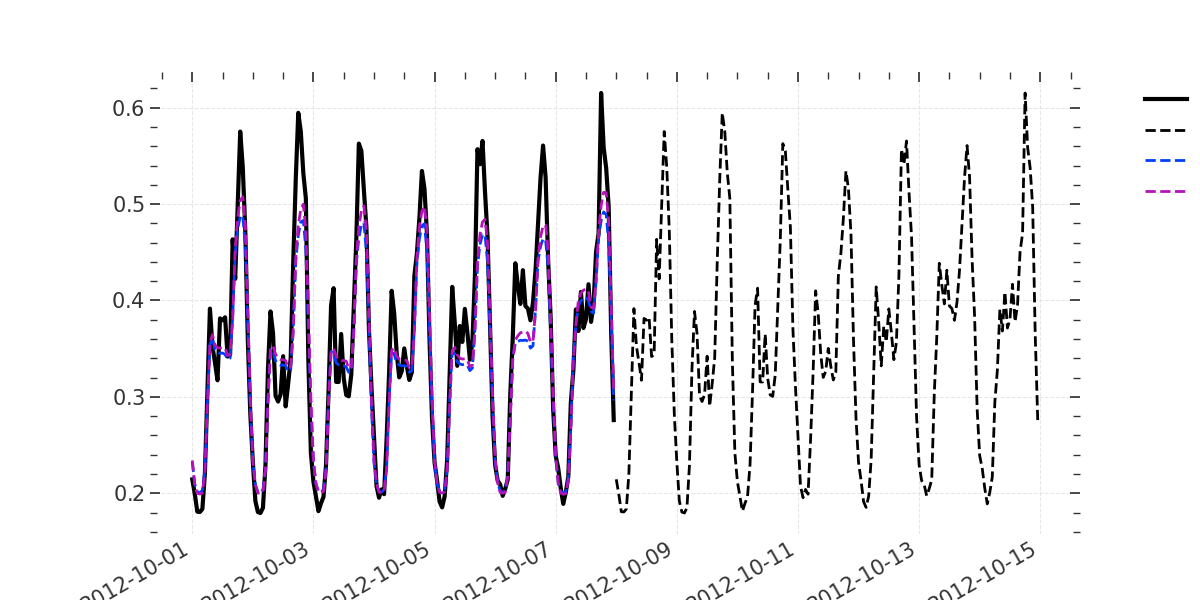

In [27]:
horizon = 24*7 #how many hours ahead


fig,  ax =  plt.subplots( figsize = (12,6))
#train.tail(horizon).plot(ax = ax, label = 'train', lw = 2, alpha = 0.2)
val.head(horizon).plot(ax = ax, label = 'val', lw = 3, alpha = 0.2, color = 'k')

for model, name  in zip(models[0:], names[0:]):
    if name == 'naive':
        pred_cv = model_naive 
        pred_train = model_naive_train
    else:
        
        pred_cv = model.predict(horizon)
        pred_train = model.predict(24*7, train[0: -24*7])
    
    
    print(f'{name} mape - train: {mape(train, pred_train):3g}')
    print(f'{name} mape - CV: {mape(val, pred_cv):3g}')
    #pred_train.tail(horizon).plot(ax = ax,  ls = '--', lw = 1, alpha = 0.0, label = name+':train')
    #color =  ax.get_lines()[-1].get_color()
    #pred_cv.head(horizon).plot(ax = ax,  ls = '--', lw = 2, alpha = 0.5, color = color, label = name+':CV')
    pred_cv.head(horizon).plot(ax = ax,  ls = '--', lw = 2, alpha = 0.5, label = name+':CV')

ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )

## random forest with all covatiates

In [ ]:
from darts.models import RandomForest

lags_horizon = 5


model_naive = val.shift(+24) #repeat value from 24 hours ago
model_naive_train = train.shift(+24) 

rf_args = {'lags': lags_horizon, 
        'n_estimators': 500, 'max_depth': 10,
        'max_features': 0.7, 'bootstrap': False}


model_rf = RandomForest(lags_future_covariates = (lags_horizon, lags_horizon) , lags_past_covariates=lags_horizon,
                    **rf_args)

cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": [frequency_covariates]}

model_rf.fit(train, **cov_args)




models = [model_naive, model_rf]
names = ['naive',  'rf']

In [ ]:
horizon = 24*7*1 #one week ahead


fig,  ax =  plt.subplots( figsize = (12,6))
train.tail(horizon).plot(ax = ax, label = 'train', lw = 3, alpha = 0.2)
val.head(horizon).plot(ax = ax, label = 'val', lw = 3, alpha = 0.2)

for model, name  in zip(models, names):
    if name == 'naive':
        pred_cv = model_naive 
        pred_train = model_naive_train
    else:
        pred_cv = model.predict(horizon, **cov_args)
        pred_train = model.predict(24*7, train[0: -24*7], **cov_args)
    
    
    print(f'{name} mape - train: {mape(train, pred_train):3g}')
    print(f'{name} mape - CV: {mape(val, pred_cv):3g}')
    pred_train.tail(horizon).plot(ax = ax,  ls = '--', lw = 2, label = name+':train')
    color =  ax.get_lines()[-1].get_color()
    pred_cv.head(horizon).plot(ax = ax,  ls = '--', lw = 2, color = color, label = name+':CV')

#put legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
